# Сравнение тарифов сотового оператора
# Описание проекта  
В компании — федеральном операторе сотовой связи, клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо провести предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении имеются данные 500 пользователей: кто они, откуда, каким тарифом пользуются, а также их данные по телефонным и интернет-соединениям за год. 

*Описание тарифов:*

**Тариф «Смарт»**
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
-	минута разговора: 3 рубля
-	сообщение: 3 рубля
-	1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
-	минута разговора: 1 рубль
-	сообщение: 1 рубль
-	1 Гб интернет-трафика: 150 рублей

**Примечание:**
Секунды округляются до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

# Цель проекта
Проанализировать поведение клиентов и сделать вывод - какой тариф выгоднее по размеру выручки.

# Описание данных

*Датасет users.csv (информация о пользователях):*  

**user_id** — уникальный идентификатор пользователя  
**first_name**  — имя пользователя  
**last_name**  — фамилия пользователя  
**age**  — возраст пользователя (лет)  
**reg_date**  — дата подключения тарифа (день, месяц, год)  
**churn_date**  — дата прекращения пользования тарифом (если значение пропущено, значит, тариф ещё действовал на момент выгрузки данных)  
**city**  — город проживания пользователя  
**tarif**  — название тарифного плана  

*Датасет calls.csv (информация о звонках):*  

**id** — уникальный номер звонка  
**call_date** — дата звонка  
**duration** — длительность звонка в минутах (пропущенные звонки имеют нулевые значения)
**user_id** — идентификатор пользователя, сделавшего звонок  

*Датасет messages.csv (информация о сообщениях):*  

**id** — уникальный номер звонка  
**message_date** — дата сообщения  
**user_id** — идентификатор пользователя, отправившего сообщение  

*Датасет internet.csv — (информация об интернет-сессиях):*  
**id** — уникальный номер сессии  
**mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)  
**session_date** — дата интернет-сессии  
**user_id** — идентификатор пользователя  

*Датасет tariffs (информация о тарифах):*  

**tariff_name** — название тарифа  
**rub_monthly_fee** — ежемесячная абонентская плата в рублях  
**minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату  
**messages_included** — количество сообщений в месяц, включённых в абонентскую плату  
**mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
**rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
**rub_per_message** — стоимость отправки сообщения сверх тарифного пакета  
**rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта) 

# Содержание

1 Обзор данных  
2 Предобработка данных  
3 Расчеты и объединение данных  
3.1 Расчет ежемесячного кол-ва и времени звонков, кол-ва смс и интернет-трафика по пользователям  
3.2 Объединение данных и расчет суммы выручки  
4 Анализ распределения кол-ва и продолжительности звонков, кол-ва смс и интернет-трафика по видам тарифов  
5 Проверка гипотез  
6 Общий вывод  

## 1 Обзор данных

Загружаем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

Загружаем данные и записываем их в соответствующие переменные:

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
sessions = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Выведем первые 5 строк каждой таблицы, общую информацию, статистическую характеристику данных и проведем проверку на пропуски и дубликаты. Для однотипных повторяющихся операций будем использовать цикл:

In [3]:
table_names = ['users', 'calls', 'messages', 'sessions', 'tariffs']  # список с названиями таблиц
variable_names = [users, calls, messages, sessions, tariffs]  # список имен переменных

for i in range(5):
    print()
    print('\033[1m''Обзор и проверка данных таблицы', table_names[i],'\033[0m')
    print('__________________________________________')
    display(variable_names[i].head())
    print()
    display(variable_names[i].info())
    display(variable_names[i].describe())
    print()
    print('\033[1m''Кол-во пропусков:\n\n''\033[0m', variable_names[i].isna().sum())
    print()
    print()
    print('\033[1m''Кол-во дубликатов:''\033[0m', variable_names[i].duplicated().sum())
    print()
    print('==========================================\n\n')


Обзор и проверка данных таблицы users 
__________________________________________


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000



Кол-во пропусков:

 user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64


Кол-во дубликатов: 0




Обзор и проверка данных таблицы calls 
__________________________________________


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000



Кол-во пропусков:

 id           0
call_date    0
duration     0
user_id      0
dtype: int64


Кол-во дубликатов: 0




Обзор и проверка данных таблицы messages 
__________________________________________


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000



Кол-во пропусков:

 id              0
message_date    0
user_id         0
dtype: int64


Кол-во дубликатов: 0




Обзор и проверка данных таблицы sessions 
__________________________________________


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000



Кол-во пропусков:

 Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64


Кол-во дубликатов: 0




Обзор и проверка данных таблицы tariffs 
__________________________________________


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000



Кол-во пропусков:

 messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64


Кол-во дубликатов: 0





Первичный обзор данных выявил наличие некоторых проблем:

1. Столбцы с датами (`reg_date` из таблицы `users`, `churn_date` из таблицы `users`, `call_date` из таблицы `calls`, `message_date` из таблицы `messages` и `session_date` из таблицы `sessions` имеют тип `object`.  
2. Столбец `duration` датафрейма `calls` имеет дробные значения, а звонки тарифицируются по целочисленным значением, т.е. их необходимо округлить в большую сторону. Нулевые значения по условию задания являются нормой (пропущенные звонки).  
3. Датафрейм `sessions` имеет лишний столбец `Unnamed: 0`, дублирующий значения индекса. Столбец с таким названием возникает, когда данные сохраняют с указанием индекса: `df.to_csv(..., index=column)`.
4. В таблице **users** есть пропущенные значения в столбце `churn_date`, это говорит о том, что для таких клиентов договор является действующим.

Проверим, какое количество клиентов расторгло договор на момент формирования датасета:

In [4]:
print('Расторгли договор', users['churn_date'].count() / users['churn_date'].shape[0] * 100, '% клиентов')

Расторгли договор 7.6 % клиентов


Посмотрим распределение значений продолжительности звонков и объемов потраченного интернет-трафика на гистограмме. Для вывода однотипных графиков напишем простую функцию:

In [5]:
def distrib (df, parametr):
    print('\033[1m''Распределение параметра "'+parametr+'"''\033[0m')
    df.hist()  

Распределение параметра "продолжительность звонков"


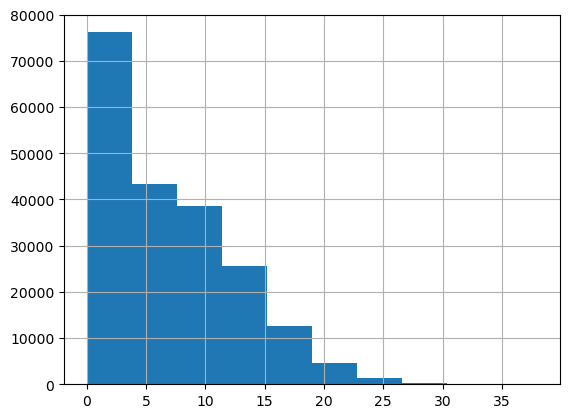

In [6]:
distrib (calls['duration'], 'продолжительность звонков')  # выводим распределение продолжительности звонков

Распределение параметра "объем трафика"


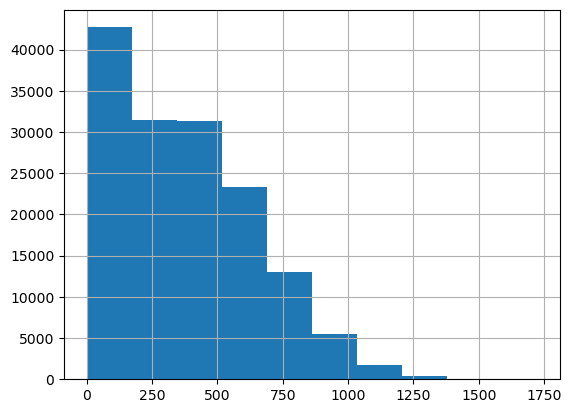

In [7]:
distrib (sessions['mb_used'], 'объем трафика')  # выводим распределение объемов трафика

Данные выглядят правдоподобно, оба графика имеют распределение Пуассона с обрывом слева, это связано с наличием ограничения по диапазону значений (все они больше или равны нулю).

**Вывод:**

На этапе обзора данных выявлено следующее:  
1. Столбцы с датами имеют некорректный тип `object`.  
2. Данные столбца `duration` датафрейма `calls` необходимо округлить в большую сторону до целочисленных значений.
3. Датафрейм `sessions` имеет лишний столбец `Unnamed: 0`, дублирующий значения индекса.  
4. Дубликаты в данных не обнаружены.
5. На момент формирования датасета договор расторгли 7,6% клиентов.
6. Данные датасетов выглядят правдоподобно, можно продолжать работу над проектом.

## 2 Предобработка данных

Приведем нужному типу все столбцы с датами. Для однотипных действий применим функцию:

In [8]:
def date_type(df, col):
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
    df[col].info()
    print('=======================================')

In [9]:
date_type(users, 'reg_date')
date_type(users, 'churn_date')
date_type(calls, 'call_date')
date_type(messages, 'message_date')
date_type(sessions, 'session_date')

<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: reg_date
Non-Null Count  Dtype         
--------------  -----         
500 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.0 KB
<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: churn_date
Non-Null Count  Dtype         
--------------  -----         
38 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.0 KB
<class 'pandas.core.series.Series'>
RangeIndex: 202607 entries, 0 to 202606
Series name: call_date
Non-Null Count   Dtype         
--------------   -----         
202607 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.5 MB
<class 'pandas.core.series.Series'>
RangeIndex: 123036 entries, 0 to 123035
Series name: message_date
Non-Null Count   Dtype         
--------------   -----         
123036 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 961.3 KB
<class 'pandas.core.series.Series'>
RangeInde

Округлим значения столбца `duration` вверх с помощью метода `numpy.ceil()` и приведем столбец `duration` к типу `int`:

In [10]:
calls['duration'] = np.ceil(calls['duration']).astype(int)
calls['duration']

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int32

Теперь удалим лишний столбец `Unnamed: 0` из таблицы `session`:

In [11]:
sessions = sessions.loc[:, ~sessions.columns.str.contains('^Unnamed')]
sessions.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


**Вывод:**  
Все данные приведены к необходимому типу, данные по длительности звонков теперь имеют целочисленные значения, лишний столбец `Unnamed: 0` удален. Предобработка данных завершена, необходимые для проекта расчеты проведем в следующем разделе.

## 3 Расчеты и объединение данных

### 3.1 Расчет ежемесячного кол-ва и времени звонков, кол-ва смс и интернет-трафика по пользователям

Поскольку тарифные планы предусматривают ежемесячную оплату, создадим столбец `month` с номером месяца для следующих таблиц:  `calls` (из столбца `call_date`), `messages` (из столбца `message_date`) и `sessions` (из столбца session_date):

In [12]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
sessions['month'] = sessions['session_date'].dt.month

Теперь посчитаем количество сделанных звонков разговора для каждого пользователя по месяцам и сохраните в переменную `calls_per_month`:

In [13]:
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))
calls_per_month.head(15)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63
1002    6         15
        7         26
        8         42
        9         36
        10        33

Для подсчета суммы израсходованных минут разговора для каждого пользователя по месяцам, сгруппируем датафрейм аналогичным образом и сохраним в данные в переменную `minutes_per_month`:

In [14]:
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))
minutes_per_month.head(15)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414
1002    6          117
        7          214
        8          289
        9          206
        10         212

Проведем аналогичные расчеты для количества СМС и суммы интернет-трафика по месяцам:

In [15]:
# подсчёт количества отправленных сообщений для каждого пользователя по месяцам
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))
messages_per_month.head(15)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11
        8            13
        9             4
        10           10
        11           16
        12           12

In [16]:
# подсчёт потраченных мегабайт для каждого пользователя по месяцам
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})
sessions_per_month.head(15)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25

### 3.2 Объединение данных и расчет суммы выручки

Объединим все посчитанные выше значения в один датафрейм `user_behavior`.
Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах:

In [17]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим пропуски в таблице user_behavior после объединения:

In [18]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Заполним нулевыми значениями образовавшиеся пропуски в данных по количеству звонков, минут, сообщений и интернет-трафика:

In [19]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Упростим название столбца `tariff_name` таблицы `tariffs` и присоединим информацию о тарифах к нашей сводной таблице `user_behavior`:

In [20]:
# переименуем столбец tariff_name на более короткое tariff
tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)

user_behavior = user_behavior.merge(tariffs, on='tariff')  # присоединяем информацию о тарифах

Посчитаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф:

In [21]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Теперь переведем превышающие тариф мегабайты в гигабайты и сохраняем в столбец `paid_gb`:

In [22]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

И посчитаем выручку за минуты разговора, сообщения и интернет:

In [23]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

Ежемесячную выручку с каждого пользователя посчитаем и сохраним в столбец `total_cost` и выведем первые 5 строк сводной таблицы:

In [24]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']
user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,...,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb,paid_gb,cost_minutes,cost_messages,cost_gb,total_cost
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,...,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,...,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,...,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,...,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,...,1,1,0.0,0.0,0.0,0,0.0,0.0,0,1950.0


Для расчета статистических метрик создадим новый датафрейм `stats_df`, где для каждой пары "месяц-тариф" будут собраны основные характеристики:

In [25]:
# сохранение статистических метрик для каждой пары месяц-тариф
# в одной таблице stats_df (среднее значение, стандартное отклонение, медиана)

stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0
5,3,ultra,67.68,17535.55,32.30,489.65,44.84,10951.79,41.62,333.74,57.0,17495.18,20.0,403.0
6,4,smart,51.31,13462.18,30.74,367.13,25.70,5698.25,24.54,186.49,52.0,14087.65,28.0,368.5
7,4,ultra,64.09,16828.13,31.56,458.02,36.27,9718.65,37.51,267.68,61.0,16645.78,17.0,453.0
8,5,smart,55.24,15805.18,33.77,387.36,25.38,5978.23,27.04,186.60,59.0,16323.94,30.0,433.0
9,5,ultra,72.51,19363.15,37.85,510.33,41.08,10046.11,40.31,289.60,75.0,18696.43,25.0,519.0


**Вывод:**  

Все данные, необходимые для проведения дальнейшего анализа и проверки гипотез готовы, можно переходить к следующему разделу.

## 4 Анализ распределения кол-ва и продолжительности звонков, кол-ва смс и интернет-трафика по видам тарифов

Для начала проверим, сколько уникальных пользователей подключено к каждому тарифному плану:

In [26]:
print('К тарифному плану Смарт подключено', user_behavior.query('tariff == "smart"')['user_id'].nunique(), 'пользователей')
print('К тарифному плану Ультра подключено', user_behavior.query('tariff == "ultra"')['user_id'].nunique(), 'пользователей')

К тарифному плану Смарт подключено 350 пользователей
К тарифному плану Ультра подключено 148 пользователей


Посмотрим на распределение среднего количества звонков по видам тарифов и месяцам:

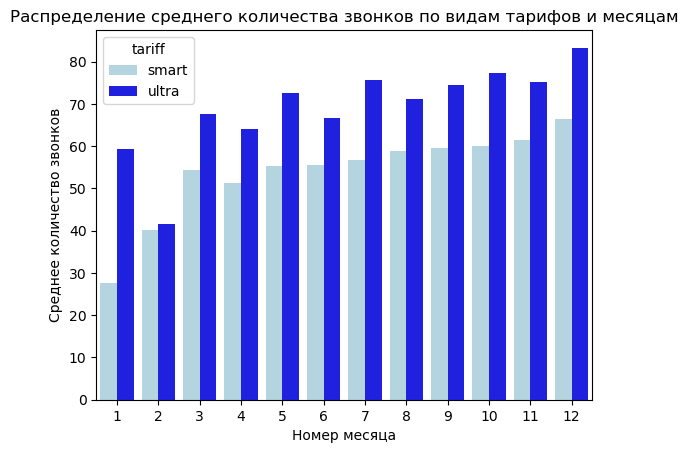

In [27]:
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение среднего количества звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

Среднее кол-во звонков у пользователей тарифа "Ультра" выше, что не удивительно, поскольку в  их тарифе лимиты на звонки значительно (в 6 раз) выше. Среднее кол-во звонков пользователей тарифа "Смарт" меньше, но в разы не отличается. Также, наблюдается тенденция к росту кол-ва звонков от месяца к месяцу.  

Посмотрим на общую гистограмму количества звонков по тарифным планам:

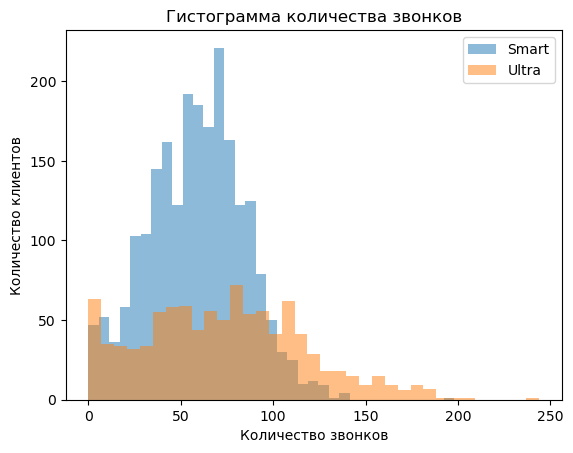

In [28]:
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.title('Гистограмма количества звонков')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов')
plt.show()

Пользователей тарифного плана "Смарт" почти в два раза больше, распределение количества звонков у них имеет выраженный пик. Распределение количества звонков среди пользователей тарифа "Ультра" более плавное, со скосом вправо, что также говорит о большем кол-ве звонков данной группы. Также наблюдается, что значительная часть пользователей обоих тарифов  вообще не пользуются функцией звонков.   
Посмотрим на распределение средней продолжительности звонков по видам тарифов и месяцам:

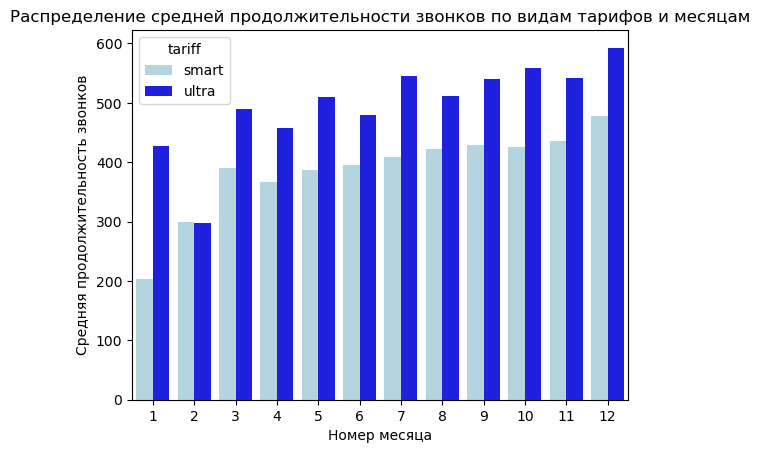

In [29]:
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение средней продолжительности звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

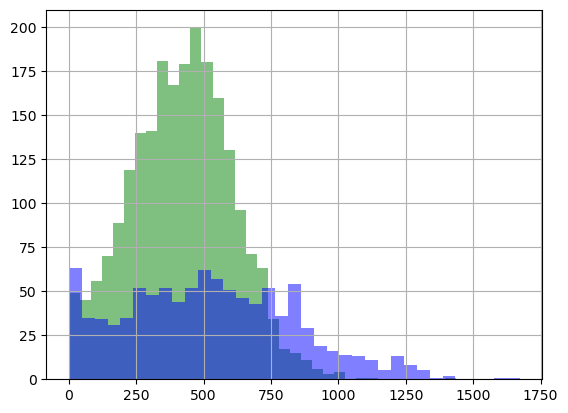

In [30]:
user_behavior[user_behavior['tariff'] =='smart']['minutes'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['minutes'].hist(bins=35, alpha=0.5, color='blue');

Средняя продолжительность звонков также растет от месяца к месяцу, и пользователи тарифа "Ультра", также ожидаемо находятся в лидерах по времени разговора.  Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности. 
Общее распределение продолжительности звонков среди пользователей тарифа "Ультра" более плавное, с обрывом слева и смещением вправо, что подтверждает тягу к долгим разговорам у части пользователей.

Проверим теперь распределение среднего количества сообщений по видам тарифов и месяцам:

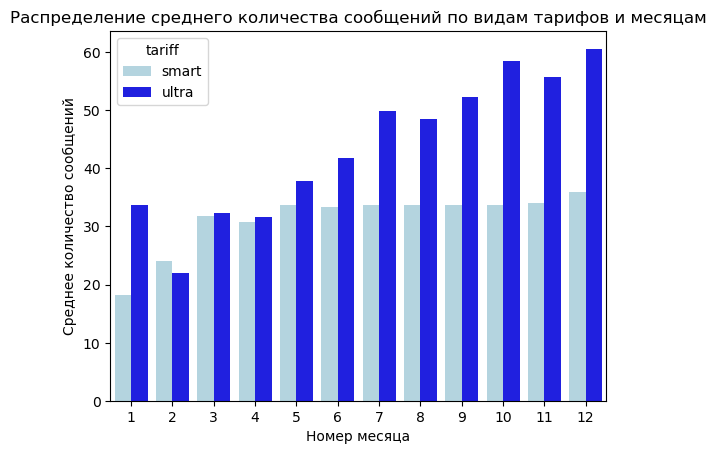

In [31]:
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение среднего количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

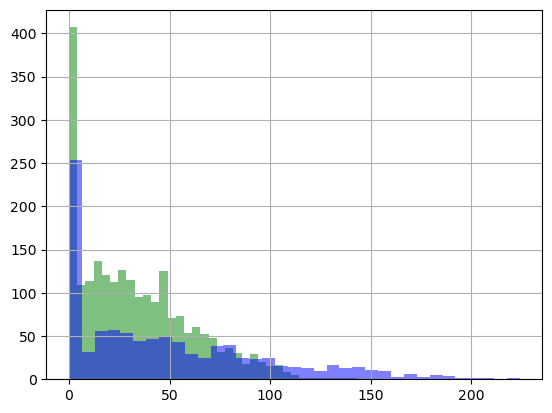

In [32]:
user_behavior[user_behavior['tariff'] =='smart']['messages'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['messages'].hist(bins=35, alpha=0.5, color='blue');

В среднем, пользователи тарифа "Ультра" отправляют большее количество сообщений - почти на 20 сообщений больше, чем пользователи тарифа "Смарт". Количество сообщений в течение года на обоих тарифах растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа "Ультра" также проявляют нелинейную положительную динамику.  
Кроме того, значительное кол-во пользователей вообще не пользуется услугой отправки СМС сообщений, она в тарифах самая непопулярная, что объяснимо - с развитием интернет-мессенджеров популярность СМС падает.

В завершение данного раздела, посмотрим распределение среднего количества трафика по видам тарифов и месяцам:

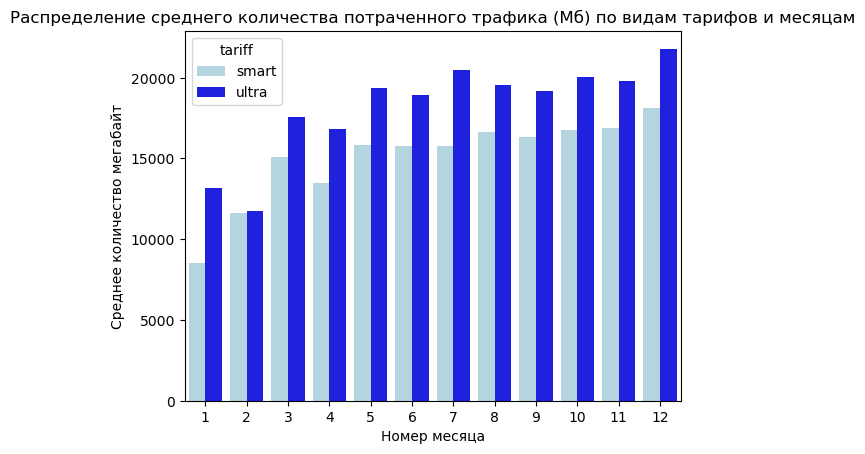

In [33]:
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение среднего количества потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

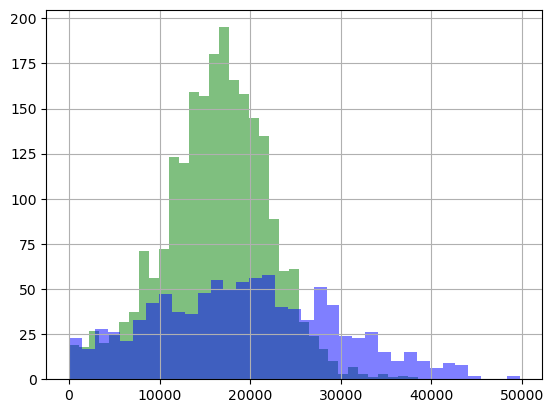

In [34]:
user_behavior[user_behavior['tariff'] =='smart']['mb_used'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['mb_used'].hist(bins=35, alpha=0.5, color='blue');

Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ. В целом, предоставление интернет-трафика является самой популярной услугой в обоих тарифных планах.

**Вывод:**

1. Самая популярная услуга - предоставление интернет-трафика, ею пользуется большинство абонентов, и они часто докупают трафик сверх тарифного лимита, а распределение на нулевой отметке наблюдается только примерно у 20 клиентов каждого тарифного плана. На втором месте - традиционные звонки, распределение звонков на нулевой отметке здесь имеют менее 50 абонентов тарифа "Смарт" и более 60 абонентов тарифа "Ультра". Услуга по отправке СМС самая не популярная, распределение количества СМС на нулевой отметке здесь самое большое - более 400 на тарифе Смарт и более 250 на тарифе Ультра.

2. В течение времени растет спрос на все виды услуг.

3. Пользователи тарифа Ультра имеют более высокие средние показатели по использованию всех услуг связи.

4. Поведение абонентов разных тарифных планов имеет отличительные особенности:

**Тариф "Смарт":**

Большинство абонентов предпочитает укладываться в установленные лимиты тарифных планов, поэтому распределения количественных показателей по услугам имеют выраженный пик в середине. Также абоненты здесь реже пользуются услугой по отправке СМС сообщений.

**Тариф "Ультра:**

Пользователи данного тарифа лидируют по приобретаемогу объему интернет-трафика. Рост потребления всех видов услуг осуществляется нелинейно.


## 5 Проверка гипотез

**Сформулируем и проверим две гипотезы:**
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
2. Пользователи из Москвы приносят больше выручки, чем пользователи из других городов.

Поскольку нам предстоит простое сравнение средних размеров выручки, будем использовать критерий Стьюдента. Для параметра `equal_var` установим значение `False`, т.к. выборки у нас разного размера и есть сомнения, что дисперсии у совокупностей одинаковые (тест посчитает дисперсии выборок по отдельности). Уровень alpha будем использовать также стандартный, равный 0,05

**Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются:**

```
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"
H_a: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"
alpha = 0.05
```

In [35]:
value_ultra = user_behavior[user_behavior['tariff'] == 'ultra'] ['total_cost']
value_smart = user_behavior[user_behavior['tariff'] == 'smart'] ['total_cost']

alpha = 0.05

results = st.ttest_ind(value_ultra, value_smart, equal_var = False)

print(results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.2606313931076085e-250
Отвергаем нулевую гипотезу


P-value оказался ниже уровня статистической значимости, значит, нулевую гипотезу о том, что статистически значимых различий в долях пользователей нет - отвергаем.

**Проверка гипотезы: пользователи из Москвы приносят больше выручки, чем пользователи из других городов:**

```
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы
H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы
alpha = 0.05
```

In [36]:
moscow_users = user_behavior[user_behavior['city'] == 'Москва'] ['total_cost']
other_users = user_behavior[user_behavior['city'] != 'Москва'] ['total_cost']

alpha = 0.05

results = st.ttest_ind(moscow_users, other_users, equal_var = False)

print(results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Результаты теста показали, что P-value оказался выше уровня статистической значимости, и следовательно, причин отвергать нулевую гипотезу, и считать, что в долях пользователей из Москвы и из других городов данной выборки есть статистически значимые различия для этих событий - нет.

## 6 Общий вывод

**В рамках работы над данным проектом сформированы следующие выводы:**
1. Все данные приведены к необходимому типу, данные по длительности звонков преобразованы в целочисленные значения, в датасете `sessions` обнаружен и удален лишний столбец `Unnamed: 0`.  

2. Произведены расчеты ежемесячного кол-ва и времени звонков, кол-ва смс и интернет-трафика по пользователям, проведено объединение данных в сводную таблицу и рассчитана сумма выручки по каждому тарифу.  

3. Анализ распределения кол-ва и продолжительности звонков, кол-ва смс и интернет-трафика по видам тарифов позволил установить следующее:  

 - самой популярной услугой является предоставление интернет-трафика, ею пользуется большинство абонентов, и они часто докупают трафик сверх тарифного лимита, на втором месте - традиционные звонки, а услуга по отправке СМС является самой не популярной;  

 - в предоставленном наборе данных наблюдается устойчивый рост спроса на все виды услуг;  

 - пользователи тарифа Ультра имеют более высокие средние показатели по использованию всех услуг связи;

 - поведение абонентов разных тарифных планов имеет отличительные особенности - для абонентов тарифа **"Смарт"** характерно удержание в пределах установленного лимита на услуги связи и отсутствие популярности услуги по отправке СМС сообщений, а для абонентов тарифа **"Ультра"** характрерно лидирование по приобретаемогу объему интернет-трафика, а также, нелинейный рост потребления всех видов услуг.  

4. В целях проверки статистически значимых различий по средней выручке между группами абонентов тарифов "Смарт" и "Ультра", а также между группами клиентов из Москвы и других городов, сформулированы и проверены 2 пары гипотез. В результате проверки установлено следующее:
 - выручка от абонентов тарифов "Смарт" и "Ультра" отличается, **тариф "Ультра" приносит большую сумму выручки**.
 - выручка от клиентов проживающих в Москве, не имеет статистически значимого отличия от выручки, получаемой от клиентов из других регионов.  

5. В качестве рекомендаций для оператора сотовой связи следует выделить два момента:
 - обратить внимание на наличие в датасетах незашифрованных персональных данных абонентов;
 - провести оптимизацию тарифных планов, что особенно актуально для тарифа "Смарт", приносящего меньшую выручку, и предусмотреть возможность индивидуальной донастройки лимитов услуг, что должно повысить лояльность клиентов и подтолкнуть их к более активному пользованию нужными услугами, и как следствие - расширить влияние оператора на рынке мобильной связи.